# What We've Learned So Far

- Adaptive Gaussian Thresholds perform the best.
- The closing morphological transformation cleans things up fairly well.
- Canny edge detection can also be helpful.

# The Game Plan

- Use `cv.matchShapes` to compare each Aurebesh letter to the alphabet.
- Create a dictionary of each of the letters where the basic is the key and the shape is the value.
- Output a TXT file with the translation(s).

# Next Steps

- Find the shape/area/contour values for the alphabet
- Assign those values to a dictionary

## Questions

- What's the minimum amount of area for a letter?
- How will I associate the lines of letters that aren't touching with each other?
  - Proximity?
  - Overall area?

In [40]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import ipympl
import imageio.v3 as iio
import skimage

In [41]:
# Close all the plots we've opened
plt.close()

# Handy widget for matplotlib
%matplotlib widget

In [42]:
# Make a variable to the image that we want to use beacuse reasons

image_file = 'memorial.jpg'
# image_file = 'aurebesh.jpg'

## Reading the Image

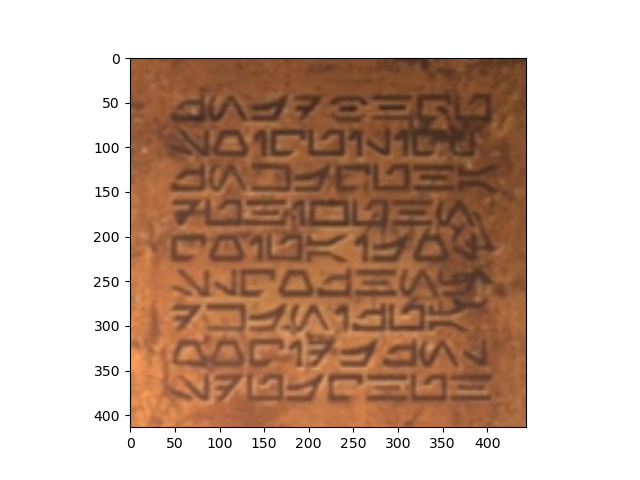

In [43]:
image = iio.imread(uri=image_file)
plt.imshow(image)

## Image in Grayscale

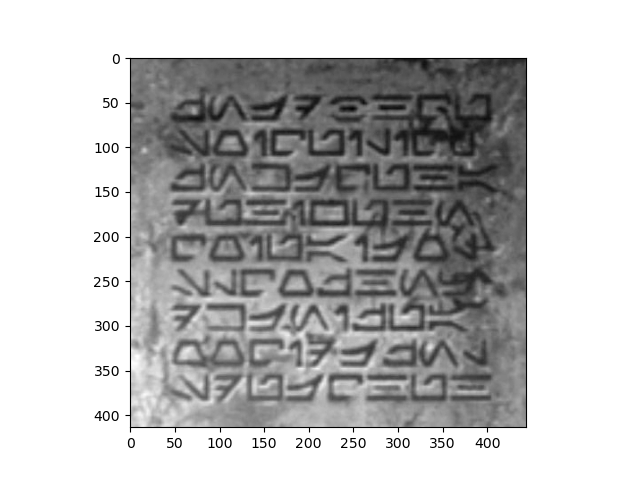

In [13]:
image_gray = iio.imread(uri=image_file, mode="L")

fig, ax = plt.subplots()
plt.imshow(image_gray, cmap="gray")

## Image with Gaussian Blur Applied

### What is Gaussian blur?

The Gaussian blur looks at one pixel and considers a rectangular group of pixels around it. This rectangular group around the pixel is called a kernel. The average color values in that kernel around the selected pixel are calculated and weighted. The pixels closer to the center pixel are given more weight than those further away from the center.

The Gaussian blur determines the rate at which the weight diminishes, and the Gaussian function uses normal distribution to calculate that weight, which is done on a channel-by-channel basis (channels are red, green, blue, and yellow?). The mean (µ) will always be 0, which is the center of the kernal, so changing the value of the variance (σ²) affects the blurring distance.

The larger the kernel, the more values there are to be averaged, thus creating more blur in an image. Because the Gaussian function uses standard deviation, the shape of the function is controlled by sigma, meaning that a larger sigma resulsts in a more flat shape while a smaller sigma results in a pronounced peak.

### How does the code work?

- `image` is image.
- `sigma` is sigma.
- `truncate` determines the radius of the kernel in terms of sigmas.
  - 2 * sigma * truncate
  - skimage default value of truncate is 4.0
- `channel_axis` tells the function that the image has three dimensions since it is a multichannel color image.

[datacarpentry.org](https://datacarpentry.org/image-processing/06-blurring/)

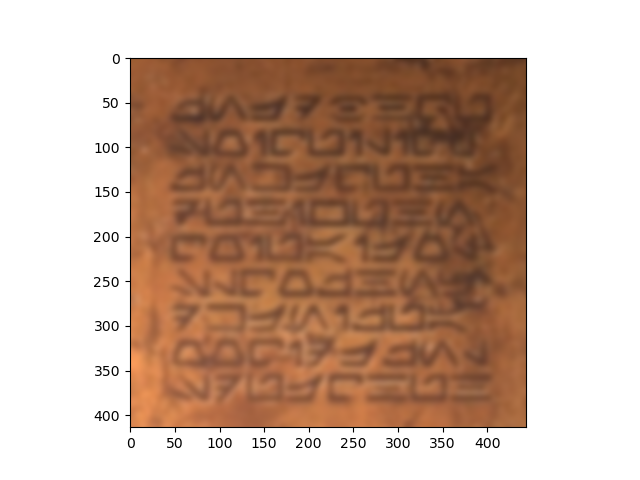

In [14]:
sigma = 3.0

blurred = skimage.filters.gaussian(image, sigma=(sigma, sigma), truncate=3.5, channel_axis=2)

fig, ax = plt.subplots()
plt.imshow(blurred)

### Gaussian Blur in Grayscale

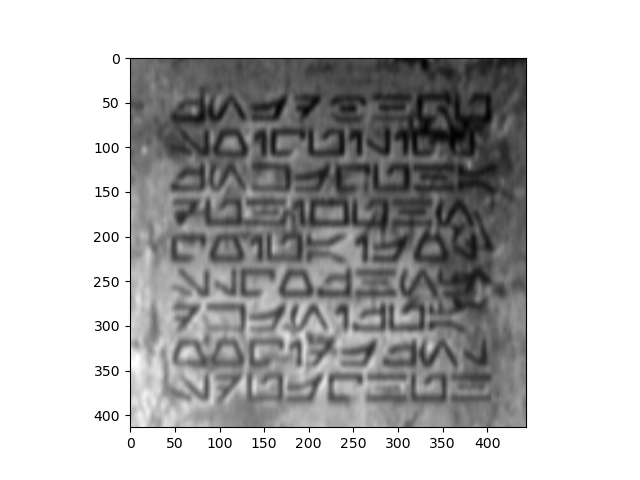

In [15]:
image_grey = skimage.color.rgb2gray(image)

blurred_image = skimage.filters.gaussian(image_grey, sigma=3.0, truncate=3.5, channel_axis=1)

fig, ax = plt.subplots()
plt.imshow(blurred_image, cmap="gray")

### Grayscale Histogram of Pixels

(0.0, 1.0)

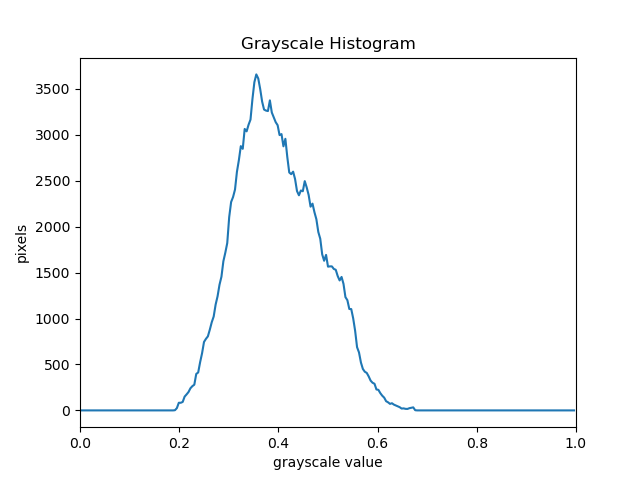

In [16]:
histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))

fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim(0, 1.0)

### Binary Masking

In [44]:
t = 0.35
binary_mask = blurred_image < t

# fig, ax = plt.subplots()
# plt.imshow(binary_mask, cmap="gray")

In [45]:
selection = image.copy()
selection[~binary_mask] = 0

# fig, ax = plt.subplots()
# plt.imshow(selection)

In [46]:
t = skimage.filters.threshold_otsu(blurred_image)
binary_mask = blurred_image > t

# fig, ax = plt.subplots()
# plt.imshow(binary_mask, cmap="gray")

selection = image.copy()
selection[~binary_mask] = 0

# fig, ax = plt.subplots()
# plt.imshow(selection)

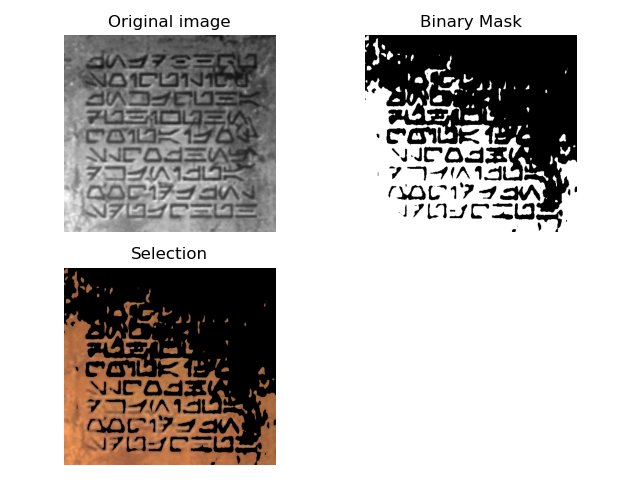

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=2)

# Get the plots ready to go
ax[0, 0].imshow(image_gray, cmap='gray')
ax[0, 0].set_title('Original image')

ax[0, 1].imshow(binary_mask, cmap='gray')
ax[0, 1].set_title('Binary Mask')

ax[1, 0].imshow(selection, cmap='gray')
ax[1, 0].set_title('Selection')

for a in ax.ravel():
    a.axis('off')

# Show the plots
plt.tight_layout()
plt.show()


### Hysteresis Threshold

Hysteresis is the lagging of an effect, similar to inertia. What this means in thresholding is that only areas that are above a low threshold and are connected to areas above a high threshold are considered. Those low threshold areas can be taken as continuations of high-confidence areas.

The thresholding technique relies on Sobel edge detection.

[scikit-image.org](https://scikit-image.org/docs/dev/auto_examples/filters/plot_hysteresis.html#sphx-glr-auto-examples-filters-plot-hysteresis-py)

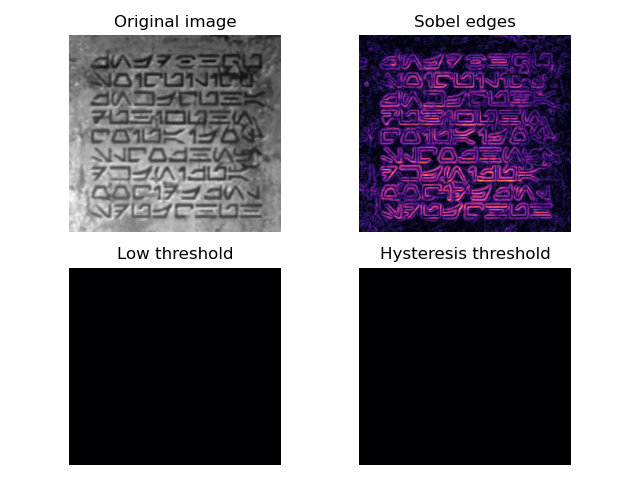

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2)

# Use Sobel edge detection to find the edges in the image
edges = skimage.filters.sobel(image_gray)

# Set the low and high threshold values (between 0 and 1)
low = 0.2
high = 0.4

# Prep the thresholds for plotting
lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = skimage.filters.apply_hysteresis_threshold(edges, low, high)

# Get the plots ready to go
ax[0, 0].imshow(image_gray, cmap='gray')
ax[0, 0].set_title('Original image')

ax[0, 1].imshow(edges, cmap='magma')
ax[0, 1].set_title('Sobel edges')

ax[1, 0].imshow(lowt, cmap='magma')
ax[1, 0].set_title('Low threshold')

ax[1, 1].imshow(hight + hyst, cmap='magma')
ax[1, 1].set_title('Hysteresis threshold')

for a in ax.ravel():
    a.axis('off')

# Show the plots
plt.tight_layout()
plt.show()


### Try all the thresholds

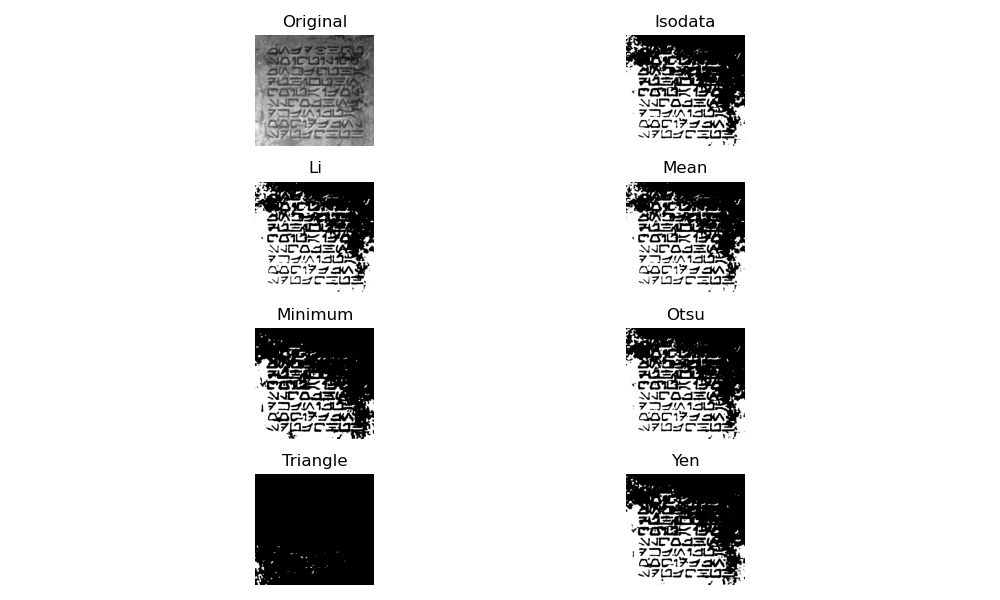

In [24]:
from skimage import data
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(image_gray, figsize=(10, 6), verbose=False)

## Local Thresholding

If the background of an image is fairly uniform, global thresholding usually does the trick. However, when the background of an image is messy, local thresholding tends to be more successful.

Local thresholding works by calculating thresholds in blocks surrounding each pixel. The threshold value that get applied is the result of the weighted mean of the local neighbors minus an offset value.

[scikit-image.org](https://scikit-image.org/docs/dev/auto_examples/applications/plot_thresholding_guide.html#sphx-glr-auto-examples-applications-plot-thresholding-guide-py)

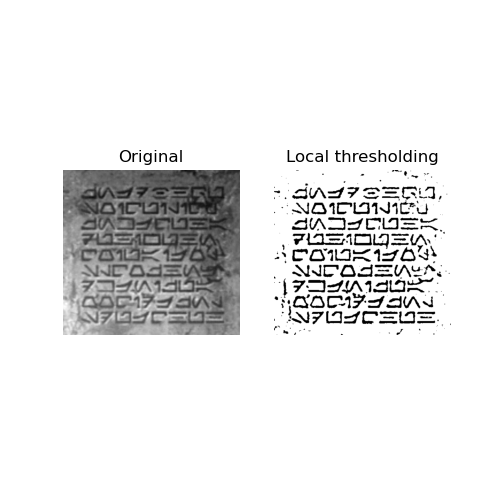

In [56]:
from skimage.filters import threshold_otsu, threshold_local

global_thresh = threshold_otsu(image_gray)
binary_global = image_gray > global_thresh

block_size = 35
local_thresh = threshold_local(image_gray, block_size, offset=10)
binary_local = image_gray > local_thresh

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(5, 5))
ax = axes.ravel()
plt.gray()

ax[0].imshow(image_gray)
ax[0].set_title('Original')

# ax[1].imshow(binary_global)
# ax[1].set_title('Global thresholding')

ax[1].imshow(binary_local)
ax[1].set_title('Local thresholding')

for a in ax:
    a.axis('off')

plt.show()

### normal stuff

In [51]:
def showimage(myimage):
    if (myimage.ndim>2):  #This only applies to RGB or RGBA images (e.g. not to Black and White images)
        myimage = myimage[:,:,::-1] #OpenCV follows BGR order, while matplotlib likely follows RGB order
         
    fig, ax = plt.subplots(figsize=[10,10])
    ax.imshow(myimage, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [48]:
img = cv.imread('memorial.jpg', 0)
img = cv.blur(img,(5,5))

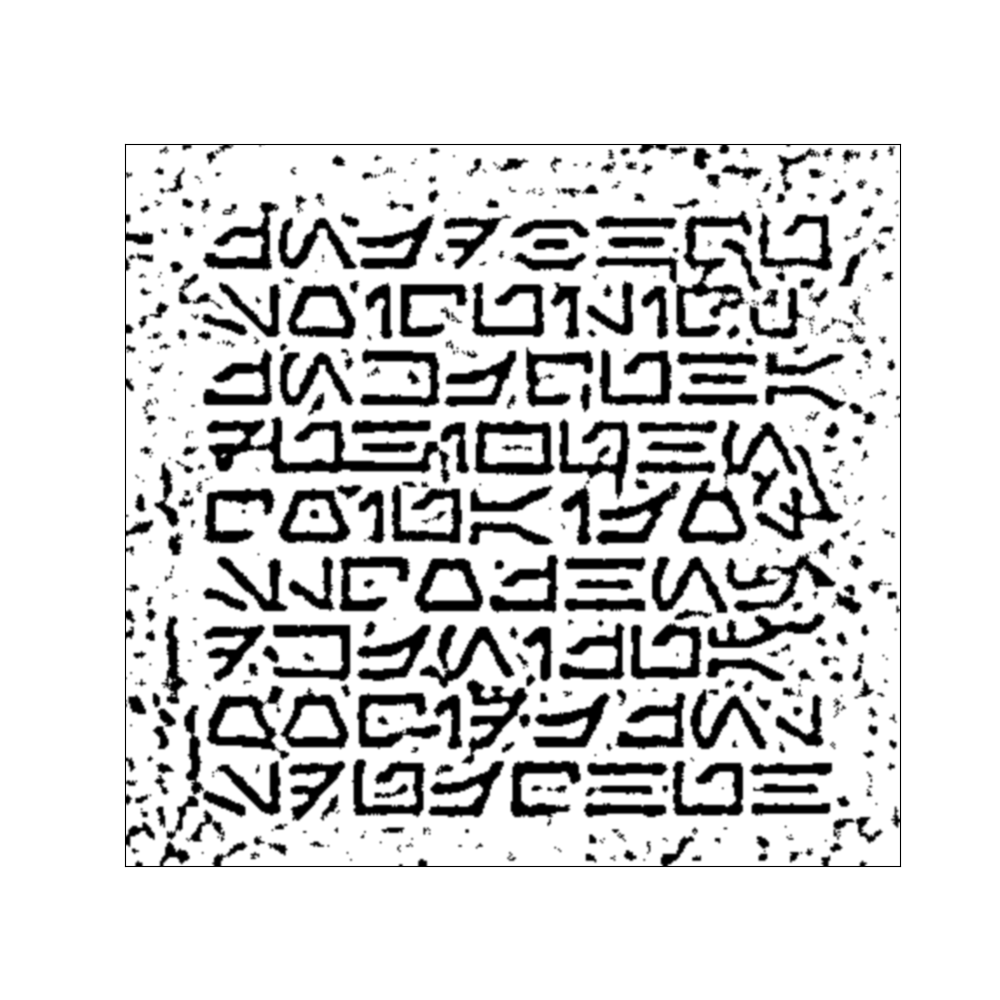

In [52]:
# Adaptive Gaussian Threshold
img_gauss = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)

showimage(img_gauss)

In [210]:
# Morphological Transformation Closing
kernel = np.ones((3,3),np.uint8)
closing = cv.morphologyEx(img_gauss, cv.MORPH_CLOSE, kernel)

# showimage(closing)

In [211]:
# Canndy Edge Detection
edges = cv.Canny(closing, 200, 250)

# showimage(edges)

In [212]:
contours, hierarchy = cv.findContours(closing, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [213]:
v1 = cv.drawContours(img, contours, -1, (0,255,0), 3)
# plt.imshow(v1)

# Simple Thresholding

In [214]:
ret,thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
ret,thresh2 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
ret,thresh3 = cv.threshold(img,127,255,cv.THRESH_TRUNC)
ret,thresh4 = cv.threshold(img,127,255,cv.THRESH_TOZERO)
ret,thresh5 = cv.threshold(img,127,255,cv.THRESH_TOZERO_INV)

In [215]:
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

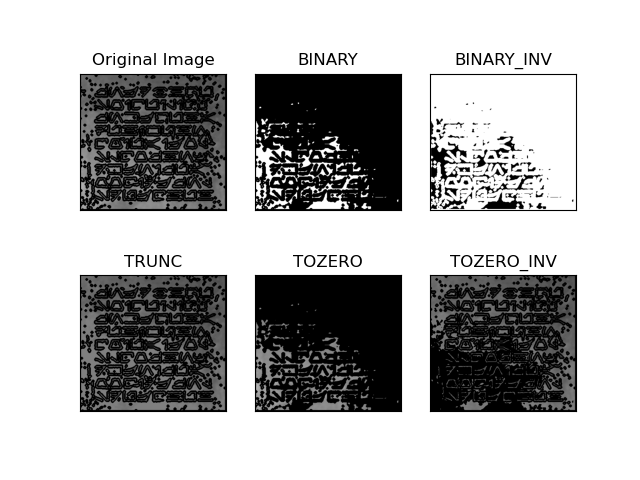

In [216]:
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

# Adaptive Thresholding

In [217]:
img = cv.imread('memorial.jpg', 0)
img = cv.medianBlur(img,5)

In [218]:
ret,th1 = cv.threshold(img,100,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)

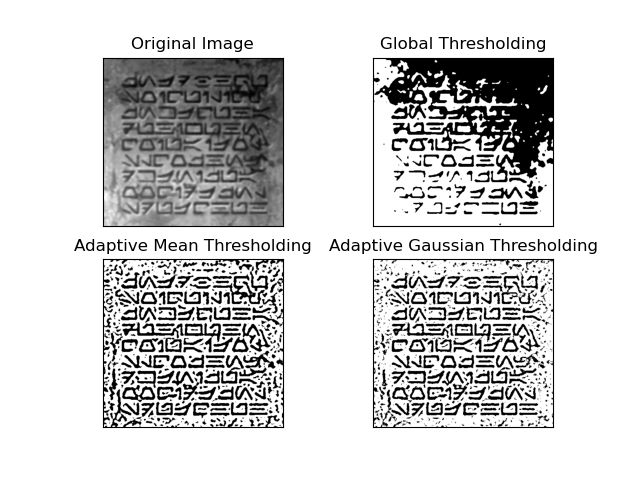

In [219]:
titles = ['Original Image', 'Global Thresholding',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

# Morphological Transformations

In [220]:
# img = cv.imread('memorial.jpg', 0)

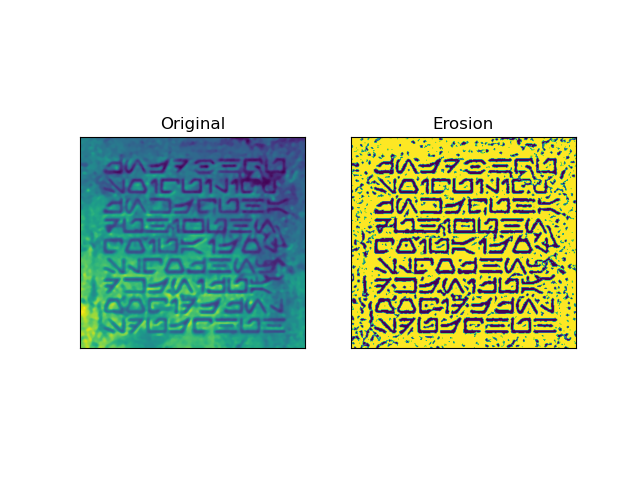

In [221]:
kernel = np.ones((1,1),np.uint8)
erosion = cv.erode(th3,kernel,iterations = 1)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(erosion),plt.title('Erosion')
plt.xticks([]), plt.yticks([])
plt.show()

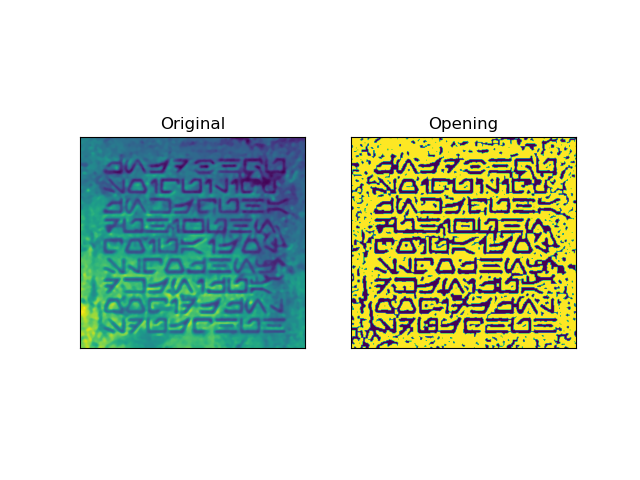

In [222]:
kernel = np.ones((5,5),np.uint8)
opening = cv.morphologyEx(th3, cv.MORPH_OPEN, kernel)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(opening),plt.title('Opening')
plt.xticks([]), plt.yticks([])
plt.show()

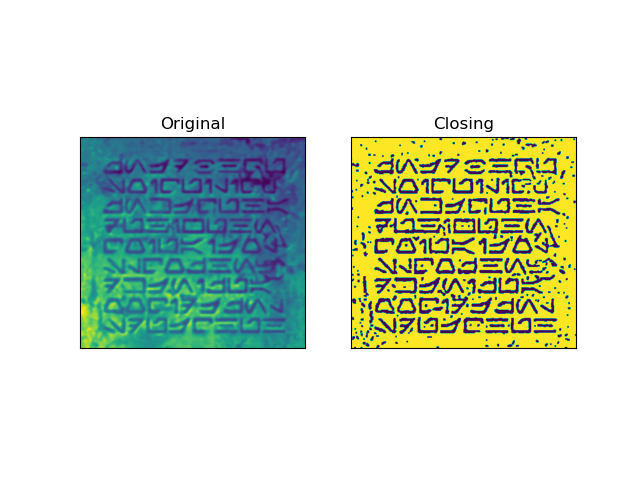

In [223]:
kernel = np.ones((3,3),np.uint8)
closing = cv.morphologyEx(th3, cv.MORPH_CLOSE, kernel)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(closing),plt.title('Closing')
plt.xticks([]), plt.yticks([])
plt.show()

# Canny Edge Detection

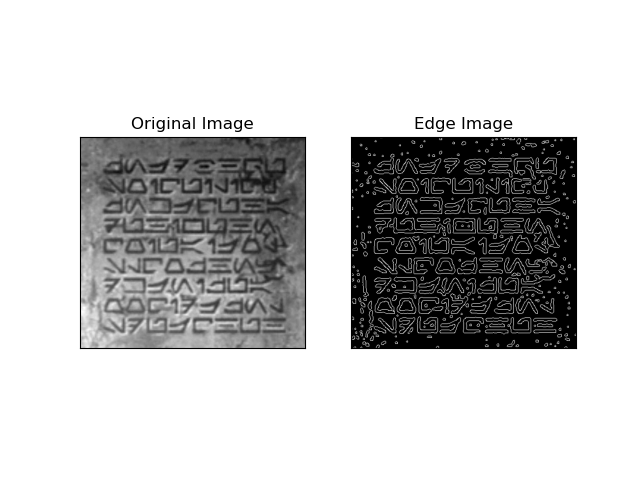

In [224]:
img = cv.imread('memorial.jpg', 0)
edges = cv.Canny(closing, 200, 250)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Contours

In [225]:
img = cv.imread('memorial.jpg')
imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [226]:
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [227]:
cnt = contours[4]
cv.drawContours(img, [cnt], 0, (0,255,0), 3)

array([[[ 50,  94, 155],
        [ 49,  93, 154],
        [ 49,  93, 154],
        ...,
        [ 33,  55,  91],
        [ 32,  54,  95],
        [ 33,  55,  96]],

       [[ 49,  93, 154],
        [ 50,  94, 155],
        [ 50,  94, 155],
        ...,
        [ 32,  55,  93],
        [ 33,  55,  96],
        [ 35,  57,  98]],

       [[ 50,  94, 155],
        [ 50,  94, 155],
        [ 51,  95, 156],
        ...,
        [ 34,  57,  95],
        [ 36,  58,  99],
        [ 36,  61, 101]],

       ...,

       [[ 81, 133, 216],
        [ 83, 135, 218],
        [ 83, 135, 218],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[ 82, 134, 217],
        [ 83, 135, 218],
        [ 84, 136, 219],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[ 85, 137, 220],
        [ 86, 138, 221],
        [ 85, 137, 220],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

## Compare Shapes

In [228]:
img1 = cv.imread('memorial.jpg', 0)
img2 = cv.imread('aurebesh.jpg', 0)

ret, thresh = cv.threshold(img1, 127, 255,0)
ret, thresh2 = cv.threshold(img2, 127, 255,0)
contours,hierarchy = cv.findContours(thresh,2,1)
cnt1 = contours[0]
contours,hierarchy = cv.findContours(thresh2,2,1)
cnt2 = contours[0]
ret = cv.matchShapes(cnt1,cnt2,1,0.0)
print( ret )

1.7976931348623157e+308


# Smoothing

In [229]:
img = cv.imread('memorial.jpg')

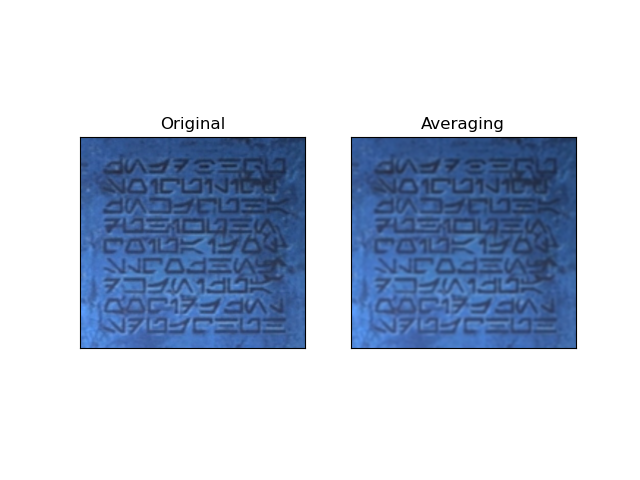

In [230]:
kernel = np.ones((5,5),np.float32)/25
dst = cv.filter2D(img,-1,kernel)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.show()

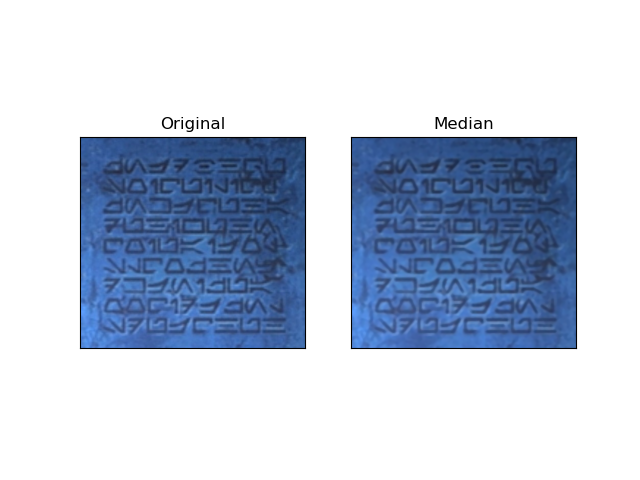

In [231]:
median = cv.medianBlur(img,5)
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(median),plt.title('Median')
plt.xticks([]), plt.yticks([])
plt.show()

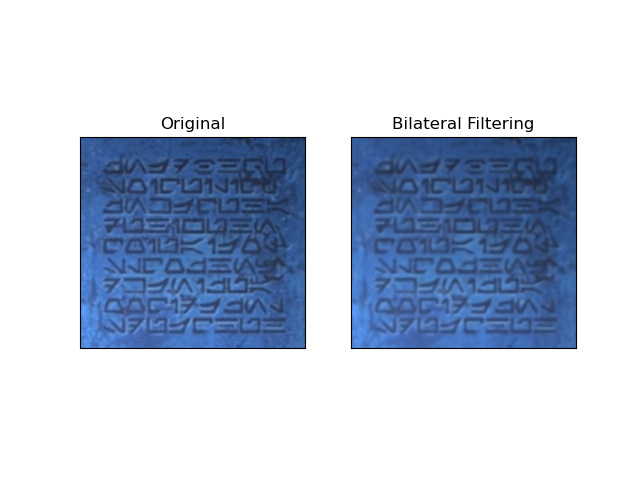

In [232]:
blur = cv.bilateralFilter(img,9,75,75)
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Bilateral Filtering')
plt.xticks([]), plt.yticks([])
plt.show()

# Otsu's Binarization

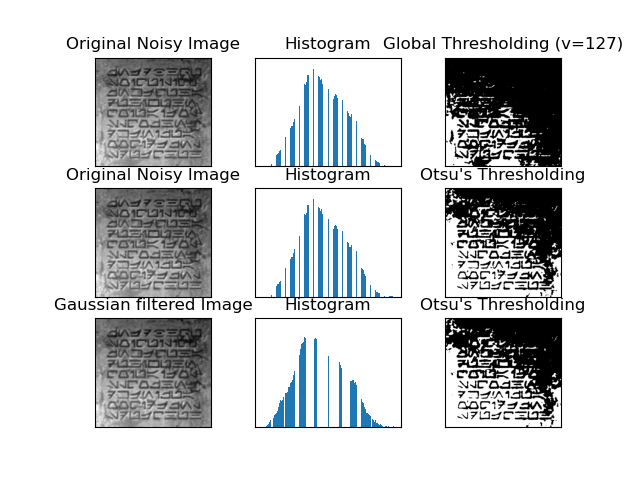

In [233]:
img = cv.imread('memorial.jpg', 0)

# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [56]:
# Close all the plots we've opened
plt.close('all')
